In [2]:
from lifelines import KaplanMeierFitter, CoxPHFitter
import matplotlib.pyplot as plt
import pandas as pd

## Data Loading

In [50]:
train_liver_labels = pd.read_excel('/media/katy/Data/ICC/HDFS/HCC_MCRC_ICC_HDFS_liver_80_20_train.xlsx')
test_liver_labels = pd.read_excel('/media/katy/Data/ICC/HDFS/HCC_MCRC_ICC_HDFS_liver_80_20_test.xlsx')
liver_features = pd.read_excel('/media/katy/Data/ICC/HDFS/HCC_MCRC_ICC_HDFS_liver_firstorderfeatures.xlsx')

train_tumor_labels = pd.read_excel('/media/katy/Data/ICC/HDFS/HCC_MCRC_ICC_HDFS_80_20_train.xlsx')
tumor_features = pd.read_excel('/media/katy/Data/ICC/HDFS/HCC_MCRC_ICC_HDFS_tumor_firstorderfeatures.xlsx')

train_liver_feats_and_labels = pd.merge(train_liver_labels, liver_features, how='inner', on=['ScoutID', 'ScoutID'])
test_liver_feats_and_labels = pd.merge(test_liver_labels, liver_features, how='inner', on=['ScoutID', 'ScoutID'])

train_tumor_feats_and_labels = pd.merge(train_tumor_labels, tumor_features, how='inner', on=['ScoutID'])

In [4]:
train_liver_feats_and_labels.columns

Index(['ScoutID', 'HDFS_Time', 'HDFS_Code', 'Cancer_Type', 'Entropy', 'Mean',
       'Variance', 'Skewness', 'Kurtosis'],
      dtype='object')

## Assumptions checking

### Liver

Text(0.5, 1.0, 'HDFS for liver Skewness levels')

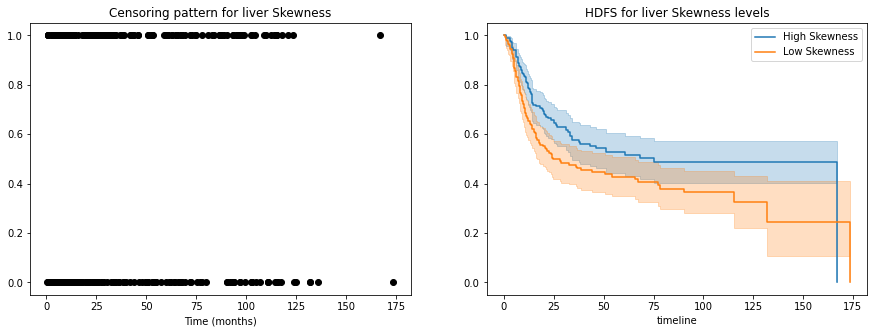

In [63]:
feature = 'Skewness'

# Censoring check
# Binarize the feature around the median for censoring check
train_feature = train_liver_feats_and_labels[feature]
bin_feature = train_feature > train_feature.median()
bin_feature = bin_feature.to_numpy(dtype="float")

high_label = "High " + feature
low_label = "Low " + feature

fig, ax = plt.subplots(1, 2, figsize=(15,5))
censor = plt.subplot(121)
ax[0].set_title("Censoring pattern for liver " + feature)
ax[0].set_xlabel("Time (months)")

censor.plot(train_liver_labels.HDFS_Time, bin_feature, 'o', color='black')

# Kaplan meier checking
high_feature = train_liver_feats_and_labels.loc[bin_feature == 1]
low_feature = train_liver_feats_and_labels.loc[bin_feature == 0]
km = plt.subplot(122)

kmf = KaplanMeierFitter()
kmf.fit(high_feature.HDFS_Time, high_feature.HDFS_Code, label=high_label)
kmf.plot_survival_function(ax=km)

kmf.fit(low_feature.HDFS_Time, low_feature.HDFS_Code, label=low_label)
kmf.plot_survival_function(ax=km)

title = "HDFS for liver " + feature + " levels"
plt.title(title)

### Tumor

Text(0.5, 1.0, 'HDFS for liver Kurtosis levels')

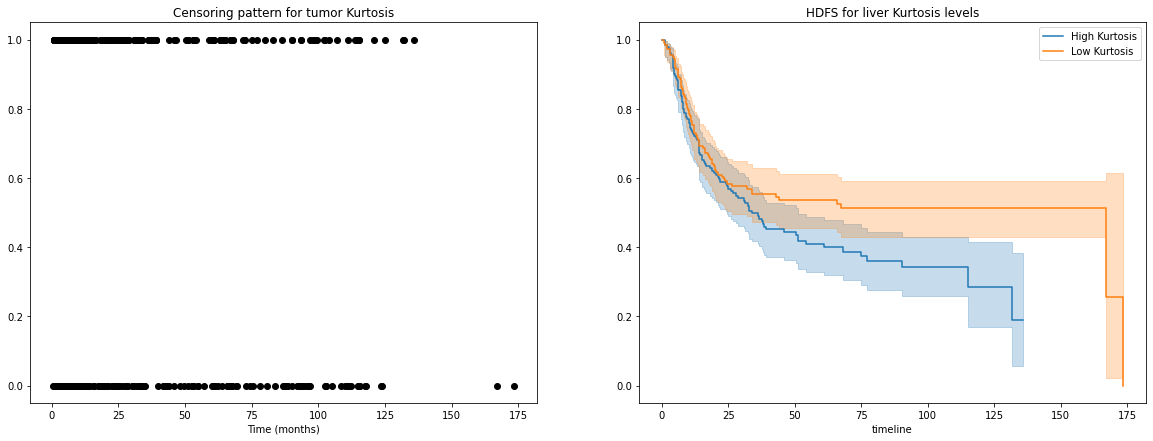

In [69]:
feature = 'Kurtosis'

# Censoring check
# Binarize the feature around the median for censoring check
train_feature = train_tumor_feats_and_labels[feature]
bin_feature = train_feature > train_feature.median()
bin_feature = bin_feature.to_numpy(dtype="float")

high_label = "High " + feature
low_label = "Low " + feature

fig, ax = plt.subplots(1, 2, figsize=(20,7))
censor = plt.subplot(121)
ax[0].set_title("Censoring pattern for tumor " + feature)
ax[0].set_xlabel("Time (months)")

censor.plot(train_tumor_labels.HDFS_Time, bin_feature, 'o', color='black')

# Kaplan meier checking
high_feature = train_tumor_feats_and_labels.loc[bin_feature == 1]
low_feature = train_tumor_feats_and_labels.loc[bin_feature == 0]
km = plt.subplot(122)

kmf = KaplanMeierFitter()
kmf.fit(high_feature.HDFS_Time, high_feature.HDFS_Code, label=high_label)
kmf.plot_survival_function(ax=km)

kmf.fit(low_feature.HDFS_Time, low_feature.HDFS_Code, label=low_label)
kmf.plot_survival_function(ax=km)

title = "HDFS for liver " + feature + " levels"
plt.title(title)

## CoxPH Modelling

In [72]:
liver_feats_for_cph = train_liver_feats_and_labels.drop(labels=["ScoutID", "Cancer_Type"], axis=1)

cph = CoxPHFitter()
cph.fit(liver_feats_for_cph, duration_col='HDFS_Time', event_col='HDFS_Code')
cph.check_assumptions(liver_feats_for_cph, p_value_threshold=0.01, show_plots=True)
cph.print_summary(model='Liver Radiographic Features', decimals=3)

Proportional hazard assumption looks okay.


/home/katy/anaconda3/envs/deepicc/lib/python3.9/site-packages/lifelines/fitters/mixins.py:108: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  for variable in self.params_.index & (columns or self.params_.index):


<lifelines.CoxPHFitter: fitted with 355 total observations, 178 right-censored observations>
             duration col = 'HDFS_Time'
                event col = 'HDFS_Code'
      baseline estimation = breslow
   number of observations = 355
number of events observed = 177
   partial log-likelihood = -932.999
         time fit was run = 2022-02-22 16:54:36 UTC
                    model = Liver Radiographic Features

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
Entropy    0.738      2.092      0.316            0.118            1.358                1.125                3.889
Mean      -0.002      0.998      0.003           -0.008            0.005                0.992                1.005
Variance  -0.000      1.000      0.000           -0.000            0.000                1.000                1.000
Skewness  -0.065      0.937      0.030           -0.123           -0.006                0.884                0.994
Kurtosis   0.001      1.001      0.000            0.000            0.002                1.000                1.002

               z     p   -log2(p)
covariate                        
Entropy    2.333 0.020      5.668
Mean      -0.481 0.630      0.666
Variance  -0.990 0.322      1.635
Skewness  -2.169 0.030      5.054
Kurtosis   2.941 0.003      8.254
---
Concordance = 0.592
Partial AIC = 1875.998
log-likelihood ratio test = 13.662 on 5 df
-log2(p) of ll-ratio test = 5.803

In [78]:
tumor_feats_for_cph = train_tumor_feats_and_labels.drop(labels=["ScoutID", "Cancer_Type", "Mean"], axis=1)

cph = CoxPHFitter()
cph.fit(tumor_feats_for_cph, duration_col='HDFS_Time', event_col='HDFS_Code')
cph.check_assumptions(tumor_feats_for_cph, p_value_threshold=0.01, show_plots=True)
cph.print_summary(model='Tumor Radiographic Features', decimals=3)

Proportional hazard assumption looks okay.


/home/katy/anaconda3/envs/deepicc/lib/python3.9/site-packages/lifelines/fitters/mixins.py:108: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  for variable in self.params_.index & (columns or self.params_.index):


<lifelines.CoxPHFitter: fitted with 356 total observations, 178 right-censored observations>
             duration col = 'HDFS_Time'
                event col = 'HDFS_Code'
      baseline estimation = breslow
   number of observations = 356
number of events observed = 178
   partial log-likelihood = -943.753
         time fit was run = 2022-02-22 16:55:54 UTC
                    model = Tumor Radiographic Features

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
Entropy    0.280      1.323      0.242           -0.194            0.754                0.823                2.126
Variance   0.000      1.000      0.000           -0.000            0.000                1.000                1.000
Skewness   0.018      1.018      0.071           -0.121            0.157                0.886                1.170
Kurtosis   0.000      1.000      0.002           -0.003            0.003                0.997                1.003

              z     p   -log2(p)
covariate                       
Entropy   1.157 0.247      2.015
Variance  0.504 0.614      0.703
Skewness  0.252 0.801      0.319
Kurtosis  0.035 0.972      0.041
---
Concordance = 0.544
Partial AIC = 1895.505
log-likelihood ratio test = 4.358 on 4 df
-log2(p) of ll-ratio test = 1.475